### 1. Библиотеки

In [1]:
import numpy as np
import pydicom as dc
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [2]:
!pip install torch
!pip install segmentation_models_pytorch

     |████████████████████████████████| 88 kB 627 kB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 376 kB 1.1 MB/s            
     |████████████████████████████████| 58 kB 4.4 MB/s             
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=8b5033390130aa9b9b87d93f2d08189663b23d677b6cca33460ea0192c55c719
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=79b53f512eeae0dfe022cd6de6a5fa96fa5f047ba6e66047fb4c9dfa15684d67
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


### 2. Считывание Train/Test в Numpy массивы
1) Изображения записаны в формате ***dicom***. Для их чтения используем специальную библиотеку *pydicom*

2) В разметке имеется всего 4 класса: 
* 0 - фон, 
* 1 - висцеральный жир, кости, органы
* 2 - мышцы и внутримышечный жир, кости
* 3 - подкожный жир


In [3]:
train_names = sorted(glob('../input/vmkiit/train/train/DICOM/*'))
test_names = sorted(glob('../input/vmkiit/test/test/DICOM/*'))
label_names = sorted(glob('../input/vmkiit/train/train/Label/*'))

train_ds = []
test_ds = []
y_train = []

for name in train_names:
    train_ds.append(dc.dcmread(name))
for name in test_names:
    test_ds.append(dc.dcmread(name))
for label_name in label_names:
    img = Image.open(label_name)
    y_train.append(np.asarray(img))
y_train = np.asarray(y_train)

In [4]:
X_train = []
X_test = []
for sample_ds in train_ds:
    X_train.append(sample_ds.pixel_array)
for sample_ds in test_ds:
    X_test.append(sample_ds.pixel_array)
X_train = np.asarray(X_train).astype(float)
X_test = np.asarray(X_test).astype(float)

In [5]:
X_test.shape, X_train.shape

((20, 512, 512), (40, 512, 512))

In [6]:
X_test.min(), X_test.max()

(-1024.0, 1324.0)

### 3. Визуализация данных

##### 3.1. Семплы и их разметка

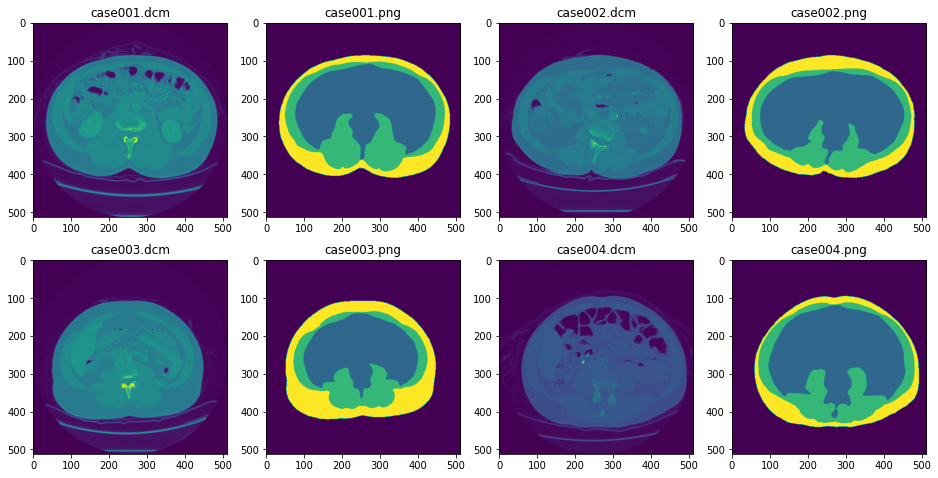

In [7]:
nrows, ncols = 2, 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_figheight(8), fig.set_figwidth(8 * ncols // nrows)
for i, (X, y) in enumerate(zip(X_train, y_train)):
    if i == nrows * ncols // 2:
        break
    ax[2 * i // ncols, 2 * i % ncols].imshow(X)
    ax[2 * i // ncols, 2 * i % ncols].set_title(f"{train_names[i].split('/')[-1]}")
    ax[(2 * i + 1) // ncols, (2 * i + 1) % ncols].imshow(y)
    ax[(2 * i + 1) // ncols, (2 * i + 1) % ncols].set_title(f"{label_names[i].split('/')[-1]}")

##### 3.2. Один из семплов в ЧБ формате 

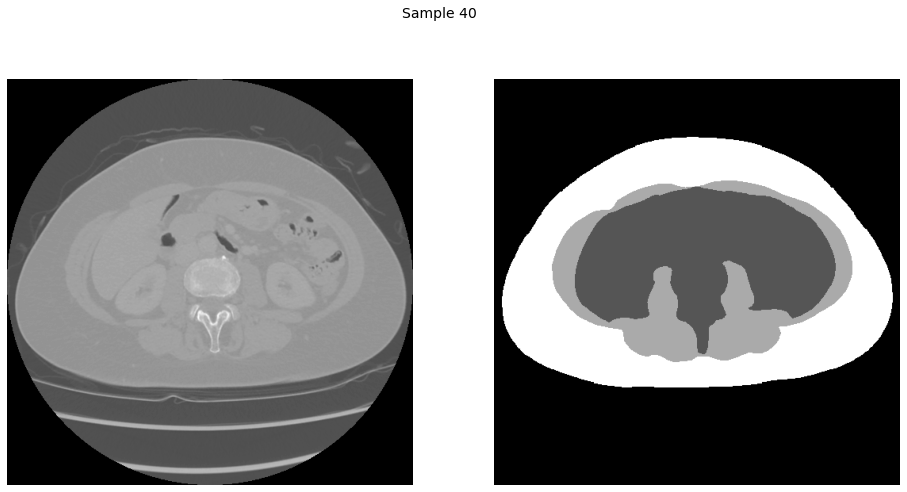

In [8]:
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8), fig.set_figwidth(16)
fig.suptitle(f'Sample {X_train.shape[0]}', fontsize=14)
ax[0].imshow(X_train[-1], cmap='gray')
ax[0].axis('off'), ax[1].axis('off')
_ = ax[1].imshow(y_train[-1], cmap='gray')

### 4. Алгоритм для Сегментации
Предлагается реализовать алгоритм для сегментации мышц и жира на снимках КТ на основе глубинного машинного обучения.

In [9]:
import segmentation_models_pytorch as smp
import torch
from segmentation_models_pytorch.encoders import get_preprocessing_fn



net = smp.Unet(
    encoder_name="se_resnext50_32x4d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [10]:
loss = smp.losses.DiceLoss(mode="multiclass")
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=net.parameters(), lr=0.0001),
])


In [11]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.preprocess = A.Compose([
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx].astype(int)
        x = np.stack([x, x, x], axis=-1)
        preprocess = self.preprocess(image=x, mask=y)
        x = preprocess['image']
        y = preprocess['mask']
        return x, y
    
dataset = Data(X_train, y_train)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [12]:
device = torch.device('cuda:0')
net = net.cuda()

In [13]:
print(X_train.shape, y_train.shape)

(40, 512, 512) (40, 512, 512)


In [14]:
from tqdm.auto import tqdm

for epoch in range(10):
    stream = tqdm(loader)
    for x, y in stream:
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        net_out = net.forward(x)
        loss_val = loss(net_out, y)
        loss_val.backward()
        optimizer.step()
        stream.set_description(f"{loss_val.item()}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
def super_solution(X_test):
    preprocess = A.Compose([
                A.Normalize(),
                ToTensorV2()
    ])
    y_test = []
    for x in tqdm(X_test):
        prep = preprocess(image=np.stack([x, x, x], axis=-1))
        x = prep['image'].unsqueeze(0)
        x = x.cuda()
        y_test.append(net(x).cpu().detach().numpy().max(axis=(0, 1)))
    
    return np.asarray(y_test).astype(np.uint8)
my_prediction = super_solution(X_test)
val_masks = super_solution(X_test)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

### 5. DICE метрика
Для проверки своих результатов на валидации можно воспользоваться numpy версией **Dice loss** или взять заточенную под Ваш фреймворк функцию отсюда (не забудьте учесть, что в задаче не два класса):

[Метрики / Лоссы](https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch)

In [16]:
def one_hot_encode(arr, num_classes=4):
    return np.squeeze(np.eye(num_classes)*[arr.reshape(-1)]).astype(np.uint8)


def dice(y_pred, y_true):
    gto = y_true
    mo = y_pred
    intersect = (gto * mo).sum()
    total = (gto + mo).sum()
    return np.mean(2. * intersect / (total + 1e-10))


y_val, y_pred = val_masks, my_prediction
dice(y_val, y_pred)

1.8983777609149204

### 6. Сохранение результатов на тестовой выборке
Сохраняем полученные маски в **csv** file

In [17]:
def rle_encoding(mask):
        dots = np.where(mask.T.flatten()==1)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b>prev+1): run_lengths.extend((b+1, 0))
            run_lengths[-1] += 1
            prev = b
        return run_lengths    


def write_submission(y):
    df = pd.DataFrame(columns=['ImageID', 'EncodedPixels'])
    for i, mask in enumerate(y):
        mask1 = (mask == 1).astype(int)
        mask2 = (mask == 2).astype(int)
        mask3 = (mask == 3).astype(int)
        df.loc[3 * i] = [str(3 * i), ""]
        df.loc[3 * i + 1] = [str(3 * i + 1), ""]
        df.loc[3 * i + 2] = [str(3 * i + 2), ""]
        encoded_mask = ' '.join([str(val) for val in rle_encoding(mask1)])
        df.loc[3 * i]['EncodedPixels'] = encoded_mask
        encoded_mask = ' '.join([str(val) for val in rle_encoding(mask2)])
        df.loc[3 * i + 1]['EncodedPixels'] = encoded_mask
        encoded_mask = ' '.join([str(val) for val in rle_encoding(mask3)])
        df.loc[3 * i + 2]['EncodedPixels'] = encoded_mask
    return df


df = write_submission(my_prediction)
df.to_csv('submission.csv', index=False)
df.shape

(60, 2)

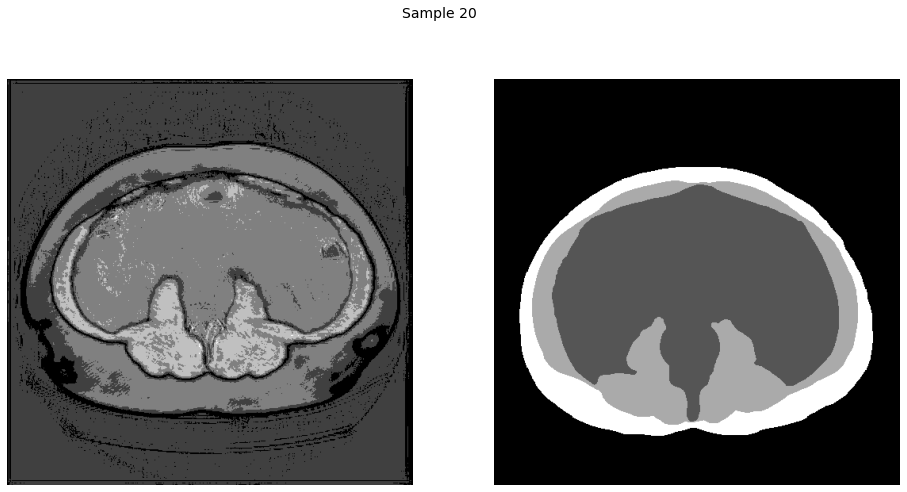

In [18]:
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8), fig.set_figwidth(16)
fig.suptitle(f'Sample {my_prediction.shape[0]}', fontsize=14)
ax[0].imshow(my_prediction[11], cmap='gray')
ax[0].axis('off'), ax[1].axis('off')
_ = ax[1].imshow(y_train[11], cmap='gray')


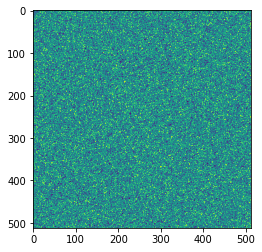

In [19]:
##Пример одной из масок, полученной с помощью super_solution функции
_ = plt.imshow(np.asarray(Image.open('../input/vmkiit/test/test/Label/case86.png')))

### 7. Возможно полезные ссылки для решения

1. [Tensorflow](https://www.tensorflow.org/)
2. [PyTorch](https://pytorch.org/)
3. [U-net](https://paperswithcode.com/method/u-net)
4. [Semantic Segmentation](https://paperswithcode.com/task/semantic-segmentation)
5. [Dice Loss](https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b)
6. [Pydicom](https://pydicom.github.io/)